In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn import feature_selection
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
#import plotly.plotly as py
#import plotly.graph_objs as go
#plotly.__version__
#plotly.tools.set_credentials_file(username='jordanvi', api_key='eWMeFHaplpUZvrjlAUZ9')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
from subprocess import check_output
print(check_output(["ls", "data/"]).decode("utf8"))

air_reserve.csv.zip
air_store_info.csv.zip
air_visit_data.csv.zip
date_info.csv.zip
hpg_reserve.csv.zip
hpg_store_info.csv.zip
sample_submission.csv.zip
store_id_relation.csv.zip



In [3]:
# Loading data
data = {
    'train': pd.read_csv('data/air_visit_data.csv.zip', compression="zip"),
    'air_store_info': pd.read_csv('data/air_store_info.csv.zip', compression="zip"),
    'hpg_store_info': pd.read_csv('data/hpg_store_info.csv.zip', compression="zip"),
    'air_reserve': pd.read_csv('data/air_reserve.csv.zip', compression="zip"),
    'hpg_reserve': pd.read_csv('data/hpg_reserve.csv.zip', compression="zip"),
    'store_id_relation': pd.read_csv('data/store_id_relation.csv.zip', compression="zip"),
    'test': pd.read_csv('data/sample_submission.csv.zip', compression="zip"),
    'date_info': pd.read_csv('data/date_info.csv.zip', compression="zip").rename(columns={'calendar_date':'visit_date'})
    }

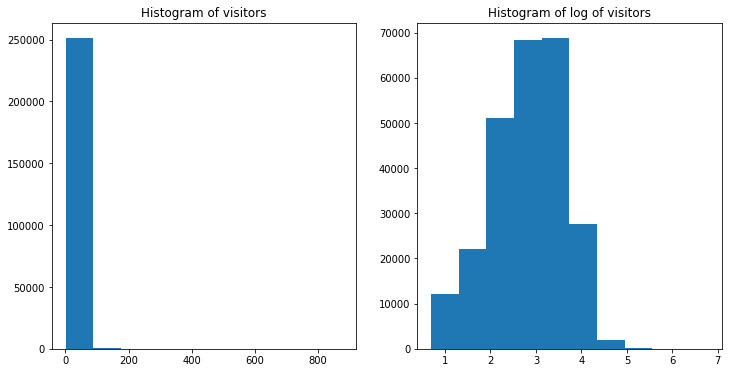

In [4]:
plt.subplots(figsize=(12,6))
plt.subplot(1, 2, 1)
data['train']['visitors'].hist()
plt.title('Histogram of visitors')
plt.grid(False)

plt.subplot(1, 2, 2)
plt.title('Histogram of log of visitors')
data['train']['visitors'].map(pd.np.log1p).hist()
plt.grid(False)

In [5]:
# bring air id to hpg reserve data
data['hpg_reserve'] = pd.merge(data['hpg_reserve'], data['store_id_relation'], how='inner', on=['hpg_store_id'])
# bring air id to hpg stores
data['hpg_store_info'] = pd.merge(data['hpg_store_info'], data['store_id_relation'], how='inner', on=['hpg_store_id'])

### Time Series of dataset

In [8]:
for df in ['air_reserve','hpg_reserve']:
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime'])
    data[df]['visit_datetime'] = data[df]['visit_datetime'].dt.date
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime'])
    data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date
    data[df]['reserve_datetime_diff'] = data[df].apply(lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
    tmp1 = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].sum().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs1', 'reserve_visitors':'rv1'})
    tmp2 = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].mean().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs2', 'reserve_visitors':'rv2'})
    data[df] = pd.merge(tmp1, tmp2, how='inner', on=['air_store_id','visit_date'])

In [9]:
data['train']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])
data['train']['dow'] = data['tra']['visit_date'].dt.dayofweek
data['train']['year'] = data['tra']['visit_date'].dt.year
data['tra']['month'] = data['tra']['visit_date'].dt.month
data['tra']['visit_date'] = data['tra']['visit_date'].dt.date

data['tes']['visit_date'] = data['tes']['id'].map(lambda x: str(x).split('_')[2])
data['tes']['air_store_id'] = data['tes']['id'].map(lambda x: '_'.join(x.split('_')[:2]))
data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date'])
data['tes']['dow'] = data['tes']['visit_date'].dt.dayofweek
data['tes']['year'] = data['tes']['visit_date'].dt.year
data['tes']['month'] = data['tes']['visit_date'].dt.month
data['tes']['visit_date'] = data['tes']['visit_date'].dt.date

In [10]:
#extracting store id and date info from test data
data['test']['air_store_id'] = data['test']['id'].map(lambda x: '_'.join(x.split('_')[:2]))
data['test']['visit_date'] = data['test']['id'].map(lambda x: str(x).split('_')[2])
data['test']['visit_date'] = pd.to_datetime(data['test']['visit_date'])
data['test']['day'] = data['test']['visit_date'].dt.day
data['test']['dow'] = data['test']['visit_date'].dt.weekday
#data['test']['dow_name'] = data['test']['visit_date'].dt.weekday_name
data['test']['year'] = data['test']['visit_date'].dt.year
data['test']['month'] = data['test']['visit_date'].dt.month
data['test']['week'] = data['test']['visit_date'].dt.week
data['test']['quarter'] = data['test']['visit_date'].dt.quarter
data['test']['visit_date'] = data['test']['visit_date'].dt.date
#data['test']['year_mth'] = data['test']['year'].astype(str)+'-'+data['test']['month'].astype(str)

In [170]:
data['train'].head(10)

,air_store_id,visit_date,visitors,day,dow,year,month,week,quarter
0,air_ba937bf13d40fb24,2016-01-13,25,13,2,2016,1,2,1
1,air_ba937bf13d40fb24,2016-01-14,32,14,3,2016,1,2,1
2,air_ba937bf13d40fb24,2016-01-15,29,15,4,2016,1,2,1
3,air_ba937bf13d40fb24,2016-01-16,22,16,5,2016,1,2,1
4,air_ba937bf13d40fb24,2016-01-18,6,18,0,2016,1,3,1
5,air_ba937bf13d40fb24,2016-01-19,9,19,1,2016,1,3,1
6,air_ba937bf13d40fb24,2016-01-20,31,20,2,2016,1,3,1
7,air_ba937bf13d40fb24,2016-01-21,21,21,3,2016,1,3,1
8,air_ba937bf13d40fb24,2016-01-22,18,22,4,2016,1,3,1
9,air_ba937bf13d40fb24,2016-01-23,26,23,5,2016,1,3,1


In [171]:
data['test'].head(10)

,visitors,air_store_id,visit_date,day,dow,year,month,week,quarter
0,0,air_00a91d42b08b08d9,2017-04-23,23,6,2017,4,16,2
1,0,air_00a91d42b08b08d9,2017-04-24,24,0,2017,4,17,2
2,0,air_00a91d42b08b08d9,2017-04-25,25,1,2017,4,17,2
3,0,air_00a91d42b08b08d9,2017-04-26,26,2,2017,4,17,2
4,0,air_00a91d42b08b08d9,2017-04-27,27,3,2017,4,17,2
5,0,air_00a91d42b08b08d9,2017-04-28,28,4,2017,4,17,2
6,0,air_00a91d42b08b08d9,2017-04-29,29,5,2017,4,17,2
7,0,air_00a91d42b08b08d9,2017-04-30,30,6,2017,4,17,2
8,0,air_00a91d42b08b08d9,2017-05-01,1,0,2017,5,18,2
9,0,air_00a91d42b08b08d9,2017-05-02,2,1,2017,5,18,2


In [11]:
data['test'] = data['test'].drop(['id'], axis=1)

In [172]:
data['hpg_store_info'].head(10)

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude,air_store_id
0,hpg_cac091abfcee2a85,Japanese style,Tōkyō-to Chūō-ku Ginza,35.668600,139.763043,air_2aab19554f91ff82
1,hpg_e87d00be48cd91c6,Japanese style,Tōkyō-to Sumida-ku Tachibana,35.704960,139.828642,air_258ad2619d7bff9a
2,hpg_03795a62e1c5f1c3,Japanese style,Hiroshima-ken Hiroshima-shi Hondōri,34.392106,132.461914,air_c47aa7493b15f297
3,hpg_51fab1683266cd55,Japanese style,Ōsaka-fu Ōsaka-shi Shinsaibashisuji,34.669514,135.501425,air_96005f79124e12bf
4,hpg_9668001cf2b8dc74,Japanese style,Tōkyō-to Taitō-ku None,35.711353,139.782684,air_f2c5a1f24279c531
5,hpg_8072ff2fb418e273,Japanese style,Tōkyō-to Kōtō-ku Minamisuna,35.670728,139.824576,air_1033310359ceeac1
6,hpg_e63863c8987bd064,Japanese style,Kanagawa-ken Yokohama-shi Nagatsutachō,35.512762,139.495733,air_640cf4835f0d9ba3
7,hpg_50378da9ffb9b6cd,Japanese style,Tōkyō-to Chiyoda-ku None,35.695780,139.768453,air_a38f25e3399d1b25
8,hpg_a9d42bc9b56916f4,Japanese style,Niigata-ken Niigata-shi Higashiōdōri,37.914180,139.060024,air_96743eee94114261
9,hpg_a786d63904735f58,Japanese style,Niigata-ken Niigata-shi Higashiōdōri,37.914180,139.060024,air_de88770300008624


### FE

In [12]:
#extract unique stores based on test data and populate dow 1 to 6
unique_stores = data['test']['air_store_id'].unique()#extract unique stores id from test data

store_7days = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) 
                    for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)
store_sum = pd.DataFrame({'air_store_id': unique_stores})

In [13]:
# mapping train data dow to stores(test data) - min, mean, median, max, count 
tmp = data['train'].groupby(['air_store_id'], as_index=False)['visitors'].sum().rename(columns={'visitors':'total_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id']) 

tmp = data['test'].groupby(['air_store_id'], as_index=False)['visitors'].sum().rename(columns={'visitors':'total_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id']) 

tmp = data['train'].groupby(['air_store_id','dow'], as_index=False)['visitors'].mean().rename(columns={'visitors':'mean_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow'])

tmp = data['test'].groupby(['air_store_id','dow'], as_index=False)['visitors'].mean().rename(columns={'visitors':'mean_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow'])

tmp = data['train'].groupby(['air_store_id','dow'], as_index=False)['visitors'].median().rename(columns={'visitors':'median_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow'])

tmp = data['test'].groupby(['air_store_id','dow'], as_index=False)['visitors'].median().rename(columns={'visitors':'median_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow'])

tmp = data['train'].groupby(['air_store_id','dow'], as_index=False)['visitors'].max().rename(columns={'visitors':'max_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow'])

tmp = data['test'].groupby(['air_store_id','dow'], as_index=False)['visitors'].max().rename(columns={'visitors':'max_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow'])

tmp = data['train'].groupby(['air_store_id','dow'], as_index=False)['visitors'].count().rename(columns={'visitors':'count_observations'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow']) 

tmp = data['test'].groupby(['air_store_id','dow'], as_index=False)['visitors'].count().rename(columns={'visitors':'count_observations'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow']) 

# map stores(test) to store genre and location detail
store_7days = pd.merge(store_7days, data['air_store_info'], how='left', on=['air_store_id']) 
#map to hpg genre and area
store_7days = pd.merge(store_7days, data['hpg_store_info'][['air_store_id','hpg_genre_name','hpg_area_name']], 
                       how='left', on=['air_store_id']) 

data['date_info']['visit_date'] = pd.to_datetime(data['date_info']['visit_date'])
data['date_info']['visit_date'] = data['date_info']['visit_date'].dt.date

hf=data['date_info']['holiday_flg']
dw=data['date_info']['day_of_week']
data['date_info']['long_wknd']=0

In [14]:
store_7days.shape

(5747, 18)

In [180]:
for i in range(len(data['date_info'])):
    if (hf[i]==1)&(dw[i]=='Friday'):
        data['date_info']['long_wknd'][i]=1
        data['date_info']['long_wknd'][i+1]=1
        data['date_info']['long_wknd'][i+2]=1
          
    if (hf[i]==1)&(dw[i]=='Monday'):
        data['date_info']['long_wknd'][i]=1
        data['date_info']['long_wknd'][i-1]=1
        data['date_info']['long_wknd'][i-2]=1

/Users/jordanvidal/python3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jordanvidal/python3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/jordanvidal/python3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-c

In [181]:
train = pd.merge(data['train'], data['date_info'], how='left', on=['visit_date']) 
test = pd.merge(data['test'], data['date_info'], how='left', on=['visit_date']) 
train = pd.merge(train, store_7days, how='left', on=['air_store_id','dow']) 
test = pd.merge(test, store_7days, how='left', on=['air_store_id','dow'])

In [182]:
for df in ['air_reserve','hpg_reserve']:
    train = pd.merge(train, data[df], how='left', on=['air_store_id','visit_date']) 
    test = pd.merge(test, data[df], how='left', on=['air_store_id','visit_date'])

In [183]:
train = train.fillna(1) #change to one for algo training
test = test.fillna(0)
train['v_no_reservation']=train['visitors']-train['reserve_visitors_air_reserve']-train['reserve_visitors_hpg_reserve']
test['v_no_reservation']=test['visitors']-test['reserve_visitors_air_reserve']-test['reserve_visitors_hpg_reserve']

In [184]:
train.shape

(252108, 33)

In [185]:
test.shape

(32019, 33)

In [187]:
train.head(5)

,air_store_id,visit_date,visitors,day,dow,year,month,week,quarter,day_of_week,holiday_flg,long_wknd,total_visitors_x,total_visitors_y,mean_visitors_x,mean_visitors_y,median_visitors_x,median_visitors_y,max_visitors_x,max_visitors_y,count_observations_x,count_observations_y,air_genre_name,air_area_name,latitude,longitude,hpg_genre_name,hpg_area_name,reserve_day_air_reserve,reserve_visitors_air_reserve,reserve_day_hpg_reserve,reserve_visitors_hpg_reserve,v_no_reservation
0,air_ba937bf13d40fb24,2016-01-13,25,13,2,2016,1,2,1,Wednesday,0,0,8908.0,0.0,23.843750,0.0,25.0,0.0,57.0,0.0,64.0,6.0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,1,1,1.0,1.0,1.0,1.0,23.0
1,air_ba937bf13d40fb24,2016-01-14,32,14,3,2016,1,2,1,Thursday,0,0,8908.0,0.0,20.292308,0.0,21.0,0.0,54.0,0.0,65.0,5.0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,1,1,1.0,1.0,1.0,1.0,30.0
2,air_ba937bf13d40fb24,2016-01-15,29,15,4,2016,1,2,1,Friday,0,0,8908.0,0.0,34.738462,0.0,35.0,0.0,61.0,0.0,65.0,5.0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,1,1,1.0,1.0,1.0,1.0,27.0
3,air_ba937bf13d40fb24,2016-01-16,22,16,5,2016,1,2,1,Saturday,0,0,8908.0,0.0,27.651515,0.0,27.0,0.0,53.0,0.0,66.0,5.0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,1,1,1.0,1.0,1.0,1.0,20.0
4,air_ba937bf13d40fb24,2016-01-18,6,18,0,2016,1,3,1,Monday,0,0,8908.0,0.0,13.754386,0.0,12.0,0.0,34.0,0.0,57.0,6.0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,1,1,1.0,1.0,1.0,1.0,4.0


In [188]:
le = LabelEncoder()
#train3['air_store_id'] = le.fit_transform(train3['air_store_id'])
#test3['air_store_id'] = le.fit_transform(test3['air_store_id'])
le.fit(train['air_store_id'])

LabelEncoder()

In [189]:
train['air_store_id'] = le.transform(train['air_store_id'])
test['air_store_id'] = le.transform(test['air_store_id'])

In [190]:
train = pd.get_dummies(data=train, columns=['air_genre_name', 'air_area_name','hpg_genre_name','hpg_area_name'])
test = pd.get_dummies(data=test, columns=['air_genre_name', 'air_area_name','hpg_genre_name','hpg_area_name'])

In [195]:
train.dtypes

air_store_id                                                     int64
visitors                                                         int64
day                                                              int64
dow                                                              int64
year                                                             int64
month                                                            int64
week                                                             int64
quarter                                                          int64
holiday_flg                                                      int64
long_wknd                                                        int64
total_visitors_x                                               float64
total_visitors_y                                               float64
mean_visitors_x                                                float64
mean_visitors_y                                                float64
median

In [194]:
train = train.drop(['visit_date','day_of_week','air_genre_name_1','air_area_name_1'], axis=1)
test = test.drop(['visit_date','day_of_week'], axis=1)

ValueError: labels ['visit_date' 'day_of_week' 'air_genre_name_1' 'air_area_name_1'] not contained in axis

### START MODELLING

In [196]:
y = train.pop('visitors')

In [197]:
train.shape

(252108, 194)

In [198]:
test.shape

(32019, 197)

In [199]:
# split data into train and test sets
#seed = 7
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=test_size)

In [200]:
from sklearn import feature_selection

In [201]:
f = feature_selection.f_regression(X_train, y_train)

### random forest

In [202]:
#RF apres FE
rf = RandomForestRegressor()
model2 = rf.fit(X_train, y_train)
predictions2 = rf.predict(X_test)

importances = rf.feature_importances_

Feature ranking:
1. feature 25 (0.871432)
2. feature 22 (0.107167)
3. feature 24 (0.009293)
4. feature 15 (0.007980)
5. feature 27 (0.000918)
6. feature 21 (0.000600)
7. feature 2 (0.000570)
8. feature 13 (0.000470)
9. feature 23 (0.000225)
10. feature 11 (0.000197)
11. feature 1 (0.000100)
12. feature 0 (0.000092)
13. feature 70 (0.000092)
14. feature 51 (0.000089)
15. feature 9 (0.000074)
16. feature 5 (0.000074)
17. feature 4 (0.000072)
18. feature 20 (0.000069)
19. feature 19 (0.000058)
20. feature 156 (0.000048)
21. feature 17 (0.000047)
22. feature 35 (0.000038)
23. feature 29 (0.000032)
24. feature 33 (0.000019)
25. feature 30 (0.000018)
26. feature 28 (0.000015)
27. feature 3 (0.000013)
28. feature 164 (0.000011)
29. feature 61 (0.000011)
30. feature 184 (0.000010)
31. feature 96 (0.000008)
32. feature 160 (0.000008)
33. feature 8 (0.000007)
34. feature 6 (0.000007)
35. feature 153 (0.000006)
36. feature 143 (0.000006)
37. feature 161 (0.000006)
38. feature 32 (0.000005)
39. fe

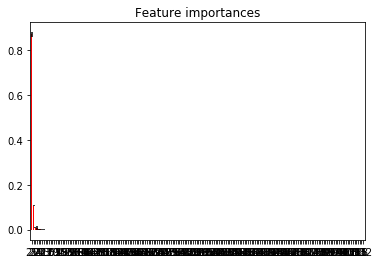

In [203]:
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

### linear regression

In [204]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

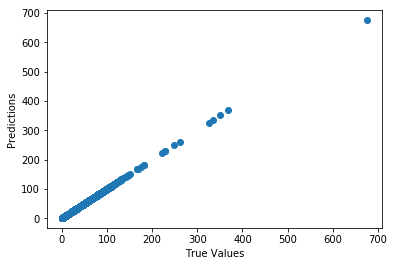

In [205]:
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [206]:
print('Score:', model.score(X_test, y_test))

Score: 1.0


In [207]:
print(mean_absolute_error(np.array(y_test), predictions))

1.80101132092e-12


In [208]:
#accuracy_score(y_true, y_pred)

In [209]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

reg = LinearRegression()

scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("log RMSE: {:.4f} +/-{:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

log RMSE: 0.0000 +/-0.0000


### RF before FE

Score: 0.0296644818211


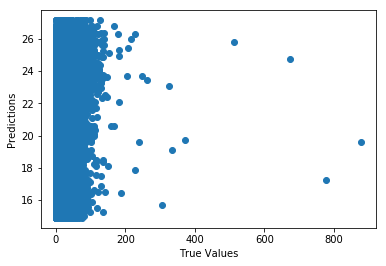

In [109]:
data['test'] = data['test'].drop(['air_store_id'], axis=1)
data['train'] = data['train'].drop(['air_store_id'], axis=1)
data['train']['visit_date'] = pd.to_datetime(data['train']['visit_date'])
data['test']['visit_date'] = pd.to_datetime(data['test']['visit_date'])
data['train'] = data['train'].drop(['visit_date'], axis=1)
data['test'] = data['test'].drop(['visit_date'], axis=1)
data['train'] = data['train'].drop(['year_mth'], axis=1)
data['test'] = data['test'].drop(['year_mth'], axis=1)

y = data['train'].pop('visitors')
# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(data['train'], y, test_size=test_size, random_state=seed)
lm = LinearRegression()
lm.fit(X_train, y_train)
predictions = lm.predict(X_test)
predictions[0:10]
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
print("Score:", lm.score(X_test, y_test))

rf = RandomForestRegressor()
model_rf = rf.fit(X_train, y_train)
predictions_rf = rf.predict(X_test)

f_rf = feature_selection.f_regression(X_train, y_train)